In [1]:
import datetime
import os

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose)
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Greys_r'

In [2]:
# loading the training and test sets from TFRecords
raw_training_dataset = tf.data.TFRecordDataset('E:/Subjects/Neural/Semantic_segmentation/train_images.tfrecords')
raw_val_dataset      = tf.data.TFRecordDataset('E:/Subjects/Neural/Semantic_segmentation/val_images.tfrecords')

In [3]:
# dictionary describing the fields stored in TFRecord, and used to extract the date from the TFRecords
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

In [4]:
# helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

In [5]:
print(len(list(parsed_training_dataset)))
print(len(list(parsed_val_dataset)))

234
26


In [7]:
# function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw, [256, 256, 1])

    image = tf.cast(image, tf.float32) * (1. / 1024)

    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw, [256, 256, 1])

    return image, label

In [8]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(
    read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [9]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1

In [10]:
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>

In [12]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

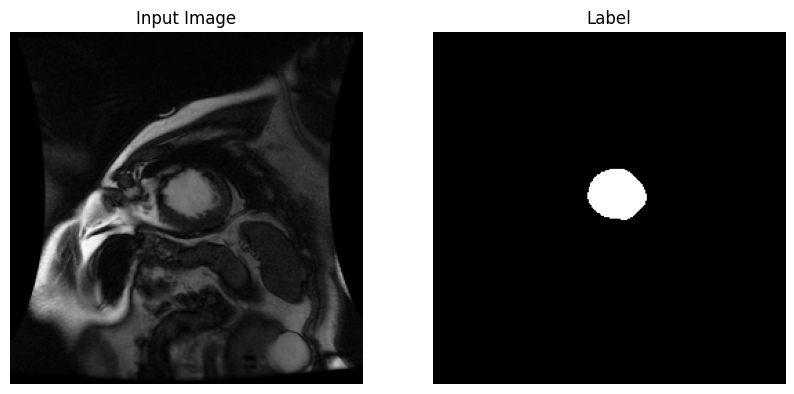

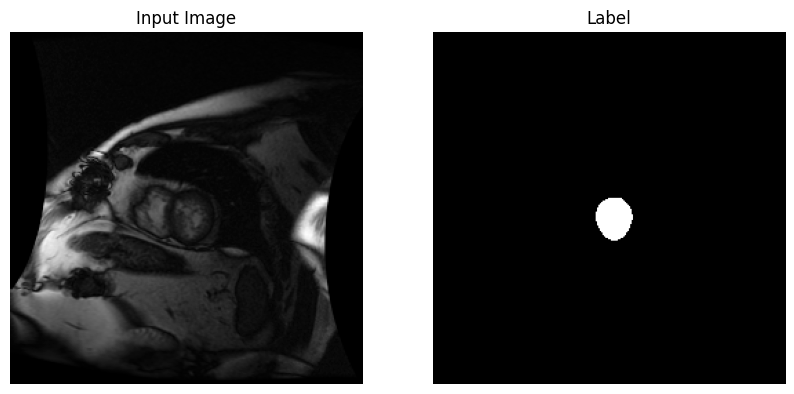

In [13]:
# display an image and label from the training set
for image, label in train.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

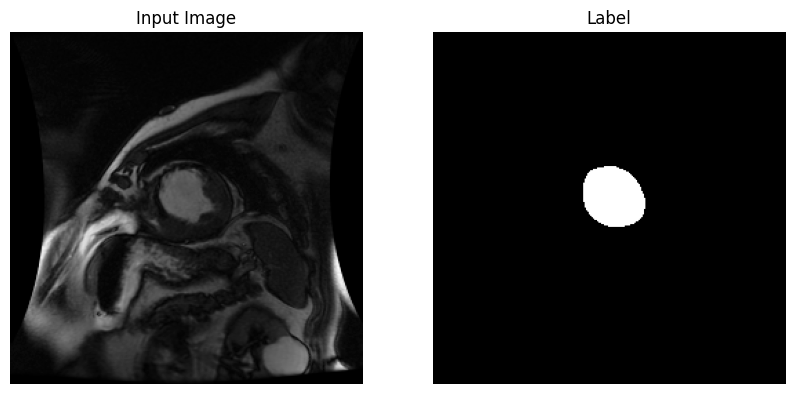

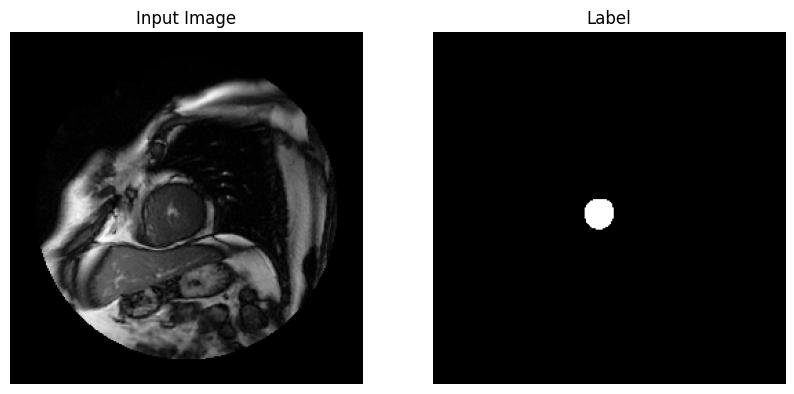

In [14]:
# display an image and label from the test set
for image, label in val.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

In [15]:
tf.keras.backend.clear_session()

# set up the model architecture
model = tf.keras.models.Sequential([
    Flatten(input_shape=[256, 256, 1]),
    Dense(64, activation='relu'),
    Dense(256*256*2, activation='softmax'),
    Reshape((256, 256, 2))
])

# specify how to train the model with algorithm, the loss function and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [16]:
# print out the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 64)                4194368   
                                                                 
 dense_1 (Dense)             (None, 131072)            8519680   
                                                                 
 reshape (Reshape)           (None, 256, 256, 2)       0         
                                                                 
Total params: 12,714,048
Trainable params: 12,714,048
Non-trainable params: 0
_________________________________________________________________


In [17]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
# function to take a prediction from the model and output an image for display
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [25]:
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])

1/1 [==============================] - 0s 126ms/step


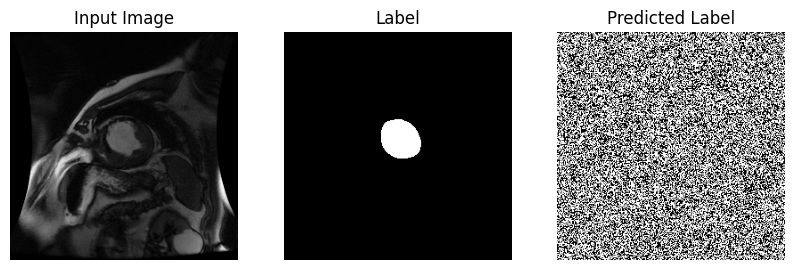

In [24]:
# show a predection, as an example
show_predictions(test_dataset)

In [30]:
# define a callback that shows image predictions on the test set
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# setup a tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Epoch 1/20
1/1 [==============================] - 0s 22ms/step- loss: 0.6931 - accuracy: 0.50


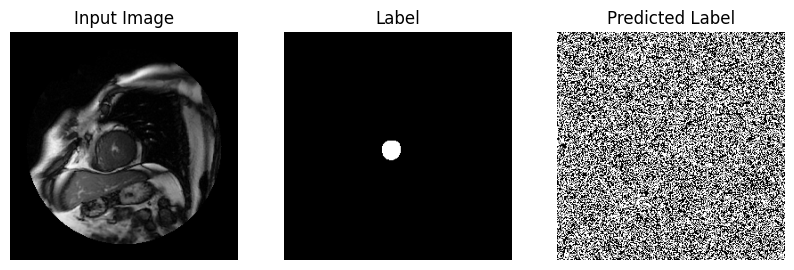


Sample Prediction after epoch 1

234/234 [==============================] - 21s 86ms/step - loss: 0.6931 - accuracy: 0.5059 - val_loss: 0.6931 - val_accuracy: 0.5124
Epoch 2/20
1/1 [==============================] - 0s 39ms/step- loss: 0.6931 - accuracy: 0.52


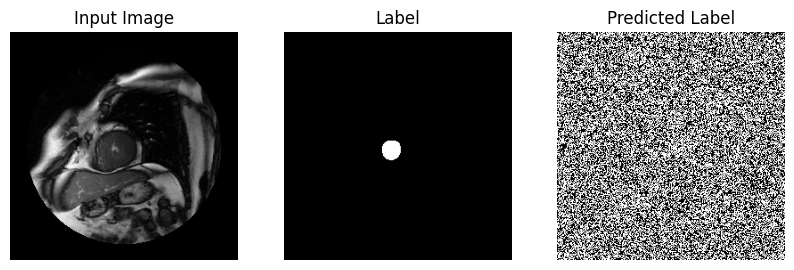


Sample Prediction after epoch 2

234/234 [==============================] - 20s 86ms/step - loss: 0.6931 - accuracy: 0.5202 - val_loss: 0.6931 - val_accuracy: 0.5292
Epoch 3/20
1/1 [==============================] - 0s 26ms/step- loss: 0.6931 - accuracy: 0.53


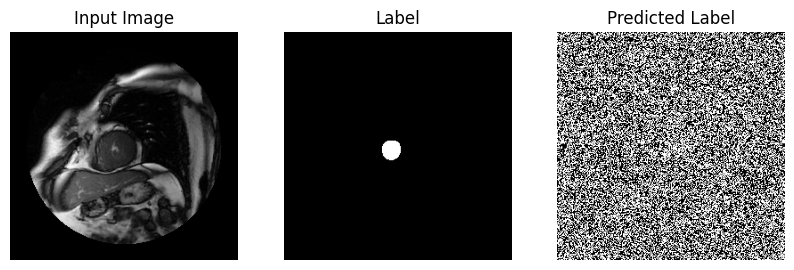


Sample Prediction after epoch 3

234/234 [==============================] - 21s 90ms/step - loss: 0.6931 - accuracy: 0.5395 - val_loss: 0.6931 - val_accuracy: 0.5530
Epoch 4/20
1/1 [==============================] - 0s 23ms/step- loss: 0.6931 - accuracy: 0.57


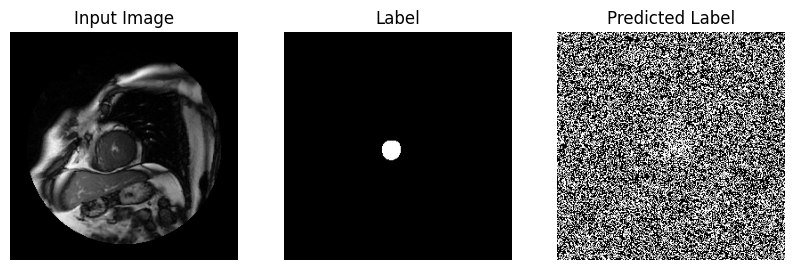


Sample Prediction after epoch 4

234/234 [==============================] - 20s 84ms/step - loss: 0.6931 - accuracy: 0.5752 - val_loss: 0.6931 - val_accuracy: 0.6064
Epoch 5/20
1/1 [==============================] - 0s 25ms/step- loss: 0.6931 - accuracy: 0.66


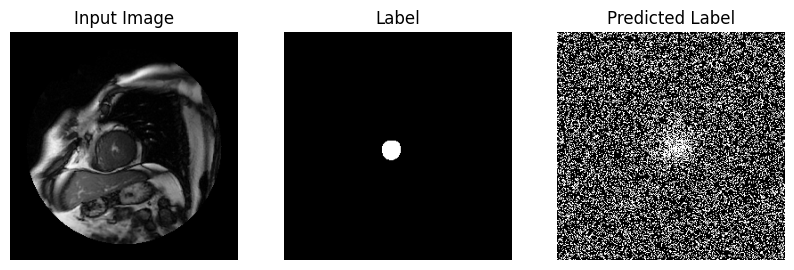


Sample Prediction after epoch 5

234/234 [==============================] - 20s 87ms/step - loss: 0.6931 - accuracy: 0.6626 - val_loss: 0.6931 - val_accuracy: 0.7379
Epoch 6/20
1/1 [==============================] - 0s 23ms/step- loss: 0.6931 - accuracy: 0.84


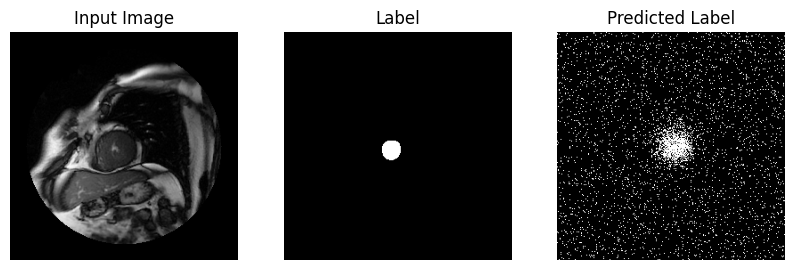


Sample Prediction after epoch 6

234/234 [==============================] - 20s 87ms/step - loss: 0.6931 - accuracy: 0.8418 - val_loss: 0.6931 - val_accuracy: 0.9424
Epoch 7/20
1/1 [==============================] - 0s 27ms/step- loss: 0.6931 - accuracy: 0.97


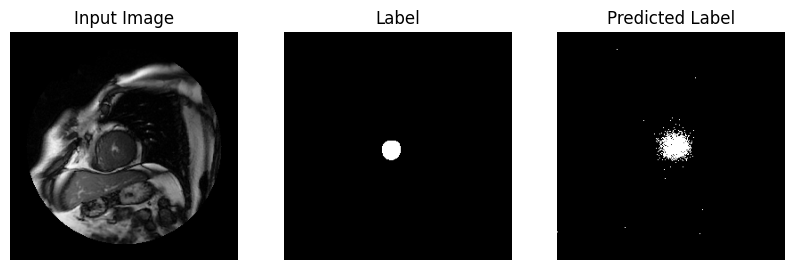


Sample Prediction after epoch 7

234/234 [==============================] - 19s 83ms/step - loss: 0.6931 - accuracy: 0.9761 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 8/20
1/1 [==============================] - 0s 26ms/step- loss: 0.6931 - accuracy: 0.98


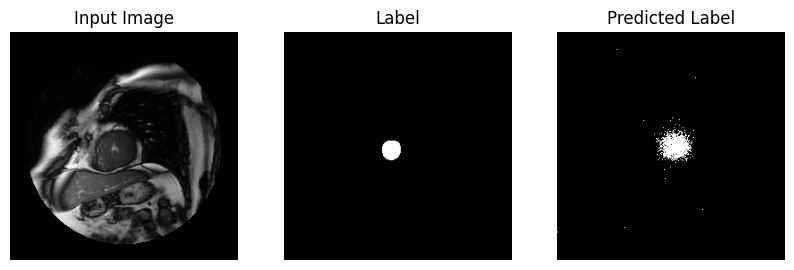


Sample Prediction after epoch 8

234/234 [==============================] - 20s 87ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 9/20
1/1 [==============================] - 0s 25ms/step- loss: 0.6931 - accuracy: 0.98


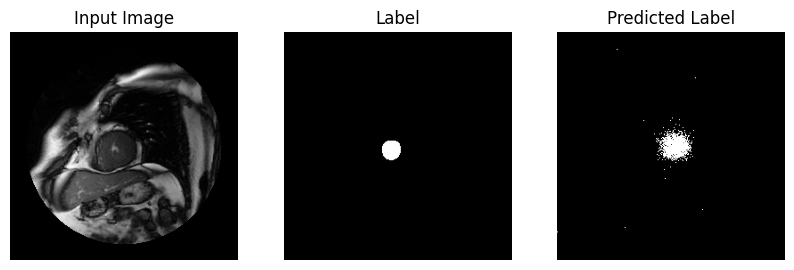


Sample Prediction after epoch 9

234/234 [==============================] - 20s 84ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 10/20
1/1 [==============================] - 0s 26ms/step- loss: 0.6931 - accuracy: 0.98


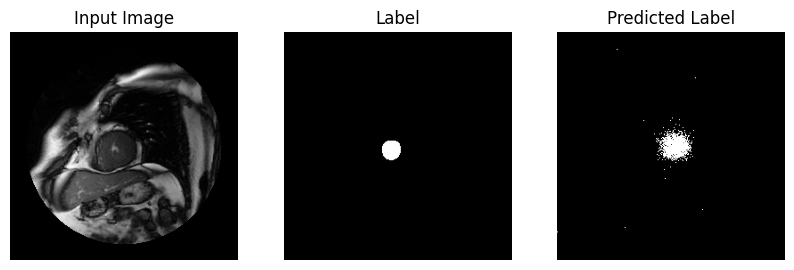


Sample Prediction after epoch 10

234/234 [==============================] - 19s 82ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 11/20
1/1 [==============================] - 0s 26ms/step- loss: 0.6931 - accuracy: 0.98


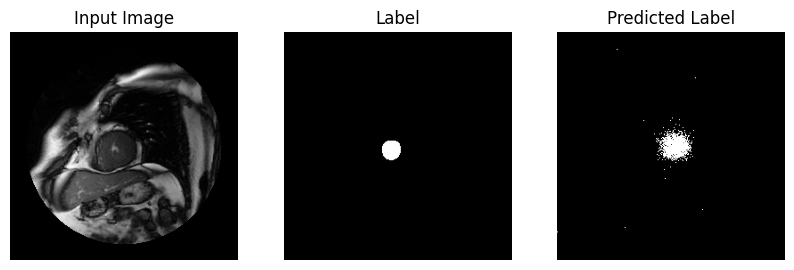


Sample Prediction after epoch 11

234/234 [==============================] - 19s 81ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 12/20
1/1 [==============================] - 0s 45ms/step- loss: 0.6931 - accuracy: 0.98


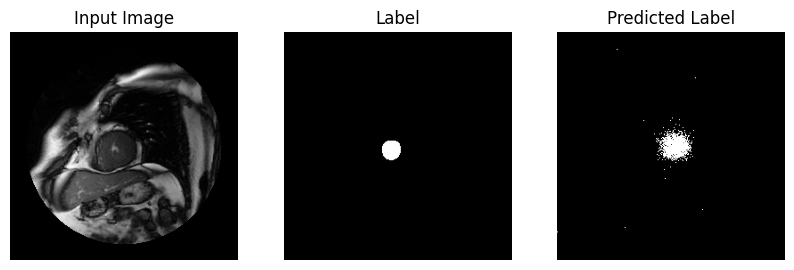


Sample Prediction after epoch 12

234/234 [==============================] - 29s 124ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 13/20
1/1 [==============================] - 0s 24ms/step- loss: 0.6931 - accuracy: 0.98


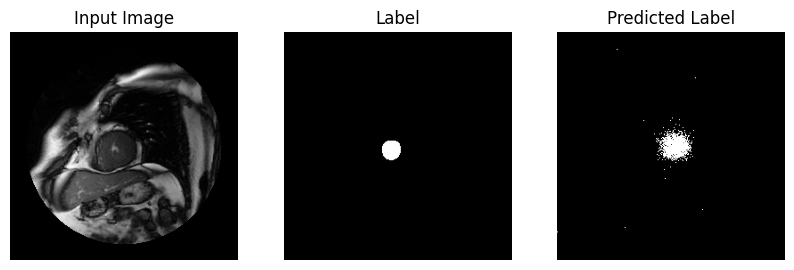


Sample Prediction after epoch 13

234/234 [==============================] - 42s 179ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 14/20
1/1 [==============================] - 0s 28ms/step- loss: 0.6931 - accuracy: 0.98


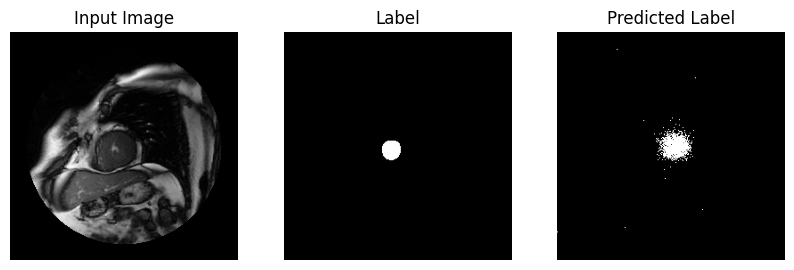


Sample Prediction after epoch 14

234/234 [==============================] - 20s 85ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 15/20
1/1 [==============================] - 0s 23ms/step- loss: 0.6931 - accuracy: 0.98


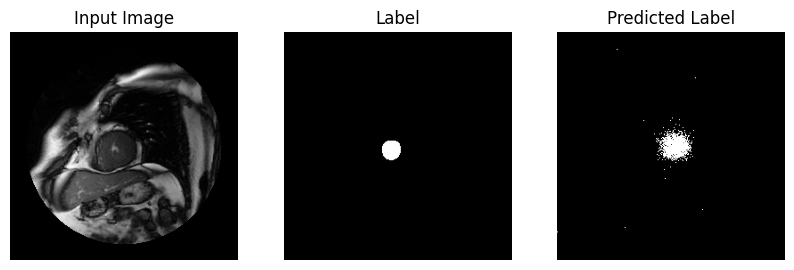


Sample Prediction after epoch 15

234/234 [==============================] - 21s 89ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 16/20
1/1 [==============================] - 0s 34ms/step- loss: 0.6931 - accuracy: 0.98


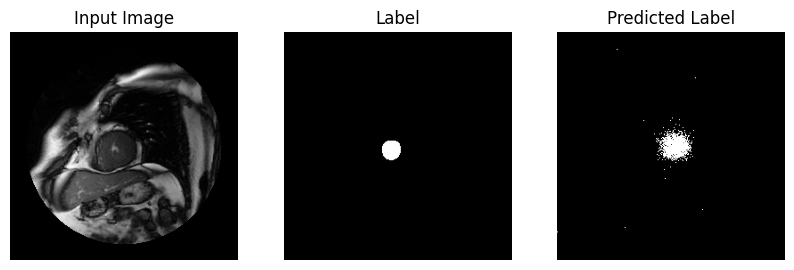


Sample Prediction after epoch 16

234/234 [==============================] - 32s 135ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 17/20
1/1 [==============================] - 0s 43ms/step- loss: 0.6931 - accuracy: 0.98


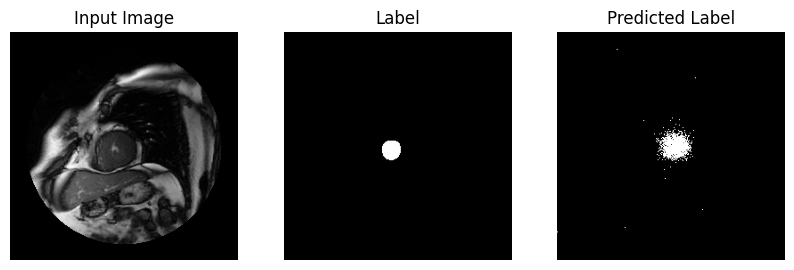


Sample Prediction after epoch 17

234/234 [==============================] - 20s 86ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 18/20
1/1 [==============================] - 0s 26ms/step- loss: 0.6931 - accuracy: 0.98


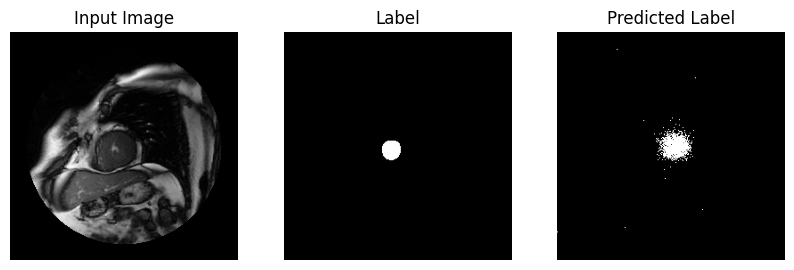


Sample Prediction after epoch 18

234/234 [==============================] - 21s 89ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 19/20
1/1 [==============================] - 0s 86ms/step- loss: 0.6931 - accuracy: 0.98


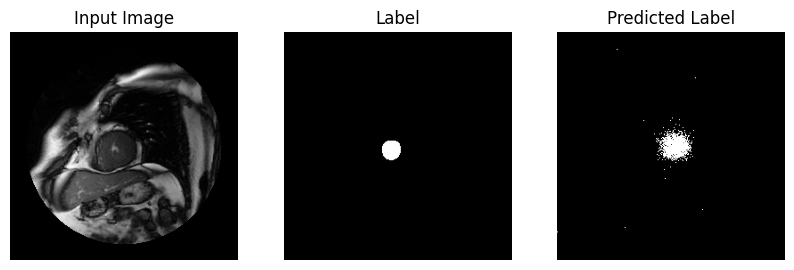


Sample Prediction after epoch 19

234/234 [==============================] - 40s 170ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 20/20
1/1 [==============================] - 0s 51ms/step- loss: 0.6931 - accuracy: 0.98


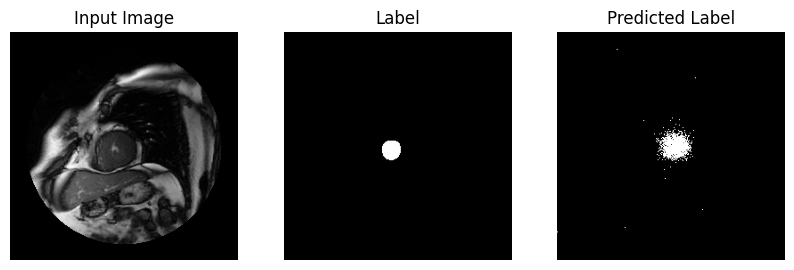


Sample Prediction after epoch 20

234/234 [==============================] - 43s 184ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867


In [26]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

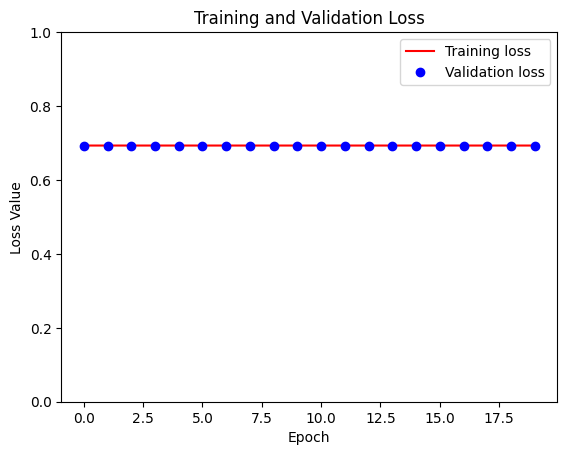

In [27]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [28]:
model.evaluate(test_dataset)

26/26 [==============================] - 1s 41ms/step - loss: 0.6931 - accuracy: 0.9867


[0.6931402683258057, 0.986683189868927]

In [29]:
%load_ext tensorboard

In [30]:
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 1).

1/1 [==============================] - 0s 22ms/step


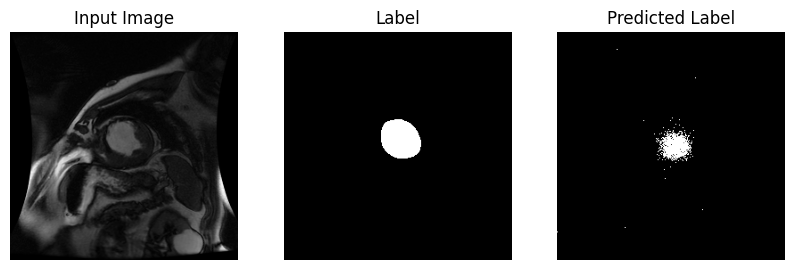

1/1 [==============================] - 0s 33ms/step


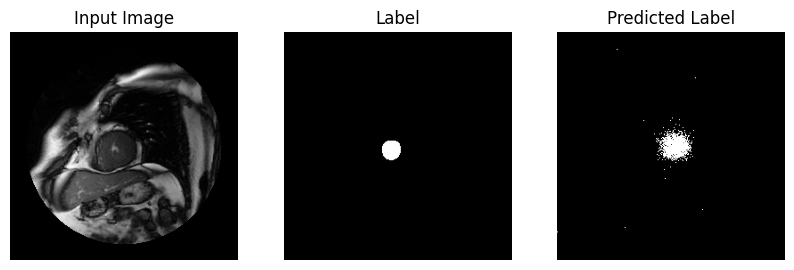

1/1 [==============================] - 0s 46ms/step


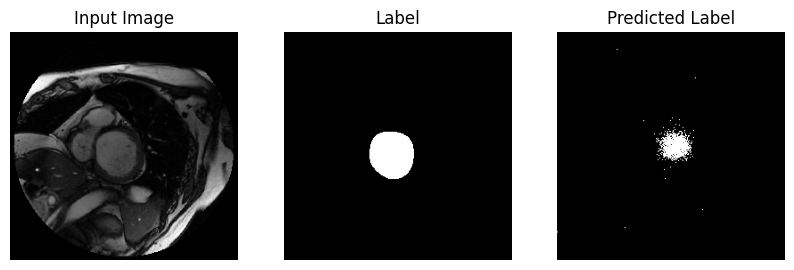

1/1 [==============================] - 0s 31ms/step


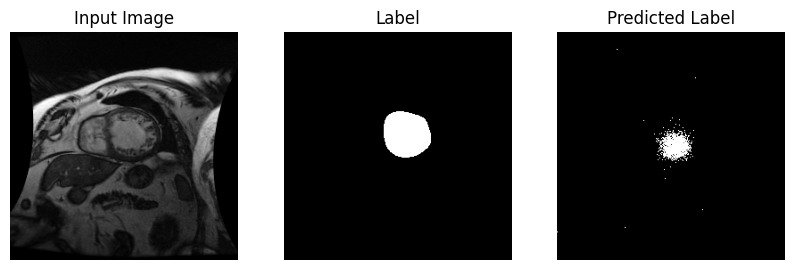

1/1 [==============================] - 0s 36ms/step


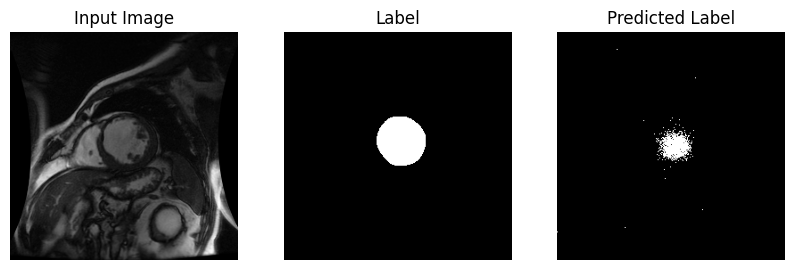

In [31]:
show_predictions(test_dataset, 5)

In [19]:
tf.keras.backend.clear_session()

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [20]:
# print out the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 128, 128, 100)     2600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 100)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 200)       500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 200)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 300)       540300    
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 300)       8

In [22]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


1/1 [==============================] - 0s 195ms/step


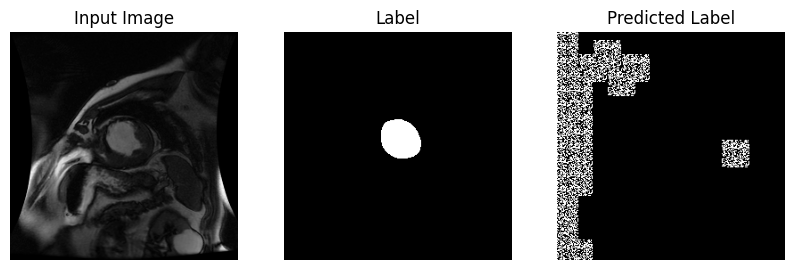

In [26]:
# show a predection, as an example
show_predictions(test_dataset)

In [27]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Epoch 1/20
1/1 [==============================] - 0s 37ms/step- loss: 0.0961 - accuracy: 0.97


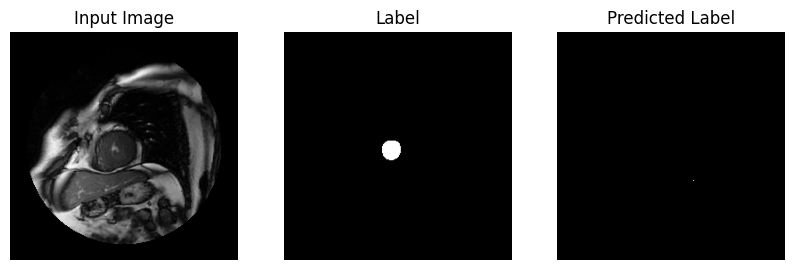


Sample Prediction after epoch 1

234/234 [==============================] - 19s 75ms/step - loss: 0.0961 - accuracy: 0.9703 - val_loss: 0.0488 - val_accuracy: 0.9830
Epoch 2/20
1/1 [==============================] - 0s 65ms/step- loss: 0.0390 - accuracy: 0.98


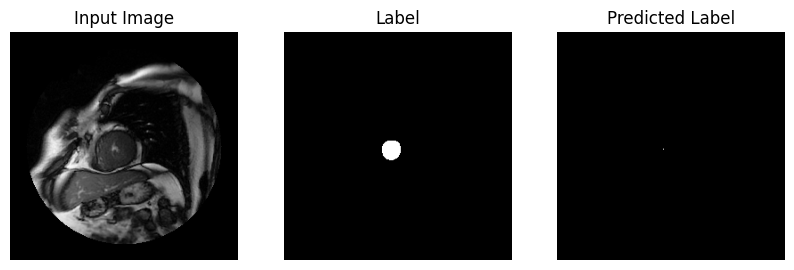


Sample Prediction after epoch 2

234/234 [==============================] - 22s 93ms/step - loss: 0.0390 - accuracy: 0.9837 - val_loss: 0.0316 - val_accuracy: 0.9831
Epoch 3/20
1/1 [==============================] - 0s 30ms/step- loss: 0.0275 - accuracy: 0.98


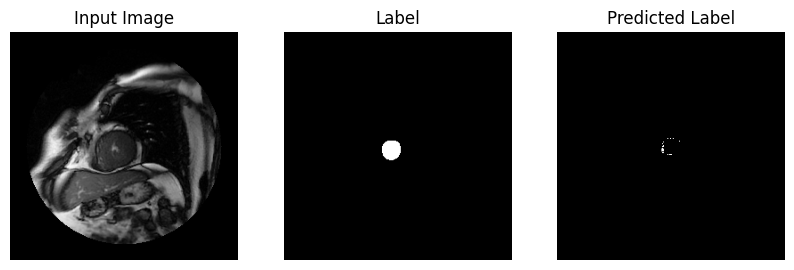


Sample Prediction after epoch 3

234/234 [==============================] - 19s 83ms/step - loss: 0.0275 - accuracy: 0.9841 - val_loss: 0.0287 - val_accuracy: 0.9836
Epoch 4/20
1/1 [==============================] - 0s 44ms/step- loss: 0.0237 - accuracy: 0.98


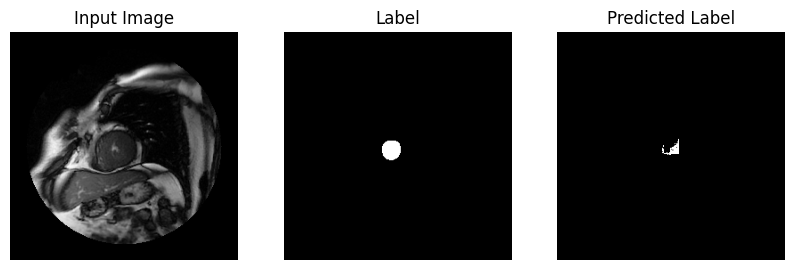


Sample Prediction after epoch 4

234/234 [==============================] - 17s 73ms/step - loss: 0.0237 - accuracy: 0.9887 - val_loss: 0.0245 - val_accuracy: 0.9881
Epoch 5/20
1/1 [==============================] - 0s 37ms/step- loss: 0.0205 - accuracy: 0.99


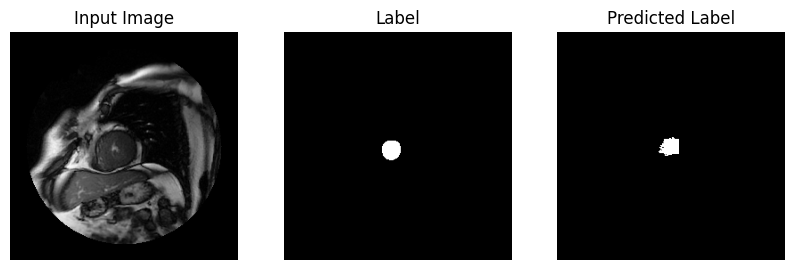


Sample Prediction after epoch 5

234/234 [==============================] - 17s 73ms/step - loss: 0.0205 - accuracy: 0.9911 - val_loss: 0.0217 - val_accuracy: 0.9903
Epoch 6/20
1/1 [==============================] - 0s 35ms/step- loss: 0.0189 - accuracy: 0.99


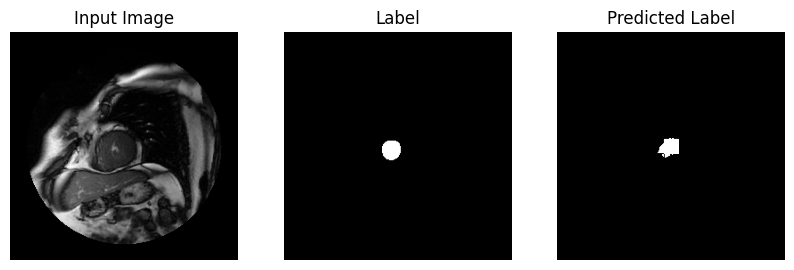


Sample Prediction after epoch 6

234/234 [==============================] - 17s 73ms/step - loss: 0.0189 - accuracy: 0.9922 - val_loss: 0.0198 - val_accuracy: 0.9920
Epoch 7/20
1/1 [==============================] - 0s 32ms/step- loss: 0.0172 - accuracy: 0.99


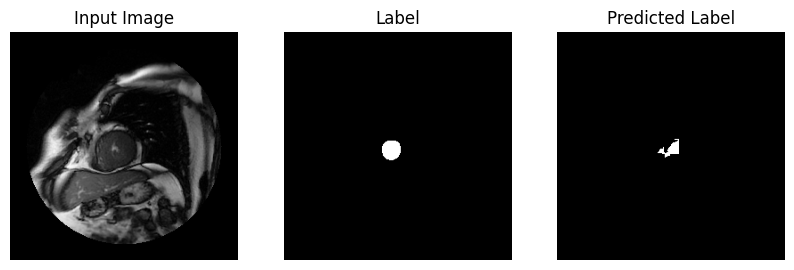


Sample Prediction after epoch 7

234/234 [==============================] - 17s 71ms/step - loss: 0.0172 - accuracy: 0.9932 - val_loss: 0.0205 - val_accuracy: 0.9912
Epoch 8/20
1/1 [==============================] - 0s 81ms/step- loss: 0.0161 - accuracy: 0.99


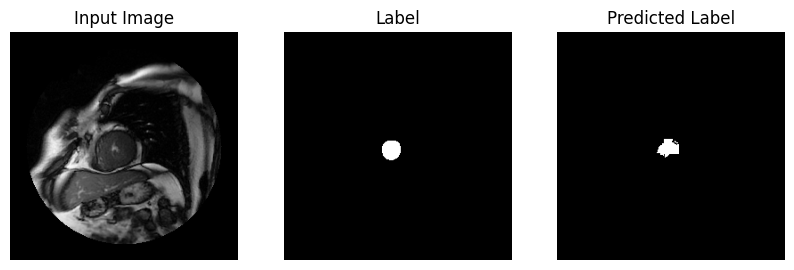


Sample Prediction after epoch 8

234/234 [==============================] - 21s 90ms/step - loss: 0.0161 - accuracy: 0.9939 - val_loss: 0.0185 - val_accuracy: 0.9924
Epoch 9/20
1/1 [==============================] - 0s 117ms/step loss: 0.0150 - accuracy: 0.99


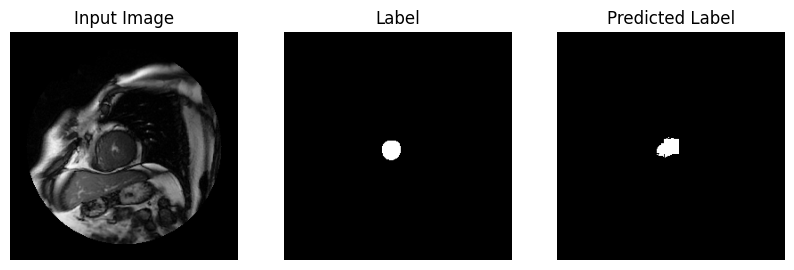


Sample Prediction after epoch 9

234/234 [==============================] - 62s 266ms/step - loss: 0.0150 - accuracy: 0.9944 - val_loss: 0.0176 - val_accuracy: 0.9930
Epoch 10/20
1/1 [==============================] - 0s 34ms/step- loss: 0.0140 - accuracy: 0.99


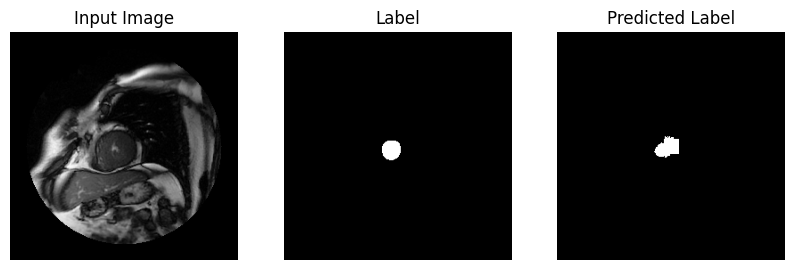


Sample Prediction after epoch 10

234/234 [==============================] - 60s 256ms/step - loss: 0.0140 - accuracy: 0.9949 - val_loss: 0.0154 - val_accuracy: 0.9941
Epoch 11/20
1/1 [==============================] - 0s 33ms/step- loss: 0.0136 - accuracy: 0.99


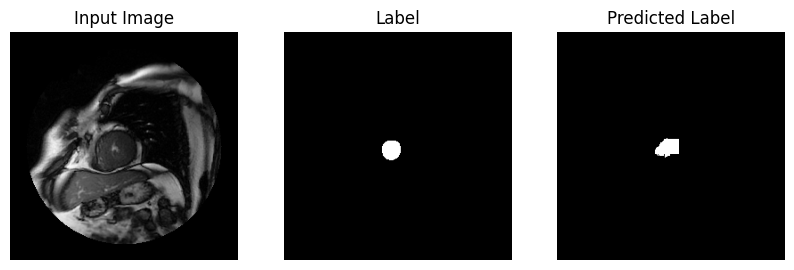


Sample Prediction after epoch 11

234/234 [==============================] - 18s 76ms/step - loss: 0.0136 - accuracy: 0.9951 - val_loss: 0.0157 - val_accuracy: 0.9937
Epoch 12/20
1/1 [==============================] - 0s 50ms/step- loss: 0.0125 - accuracy: 0.99


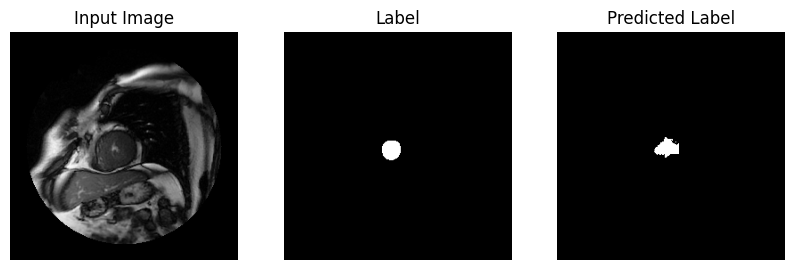


Sample Prediction after epoch 12

234/234 [==============================] - 18s 78ms/step - loss: 0.0125 - accuracy: 0.9955 - val_loss: 0.0152 - val_accuracy: 0.9941
Epoch 13/20
1/1 [==============================] - 0s 38ms/step- loss: 0.0136 - accuracy: 0.99


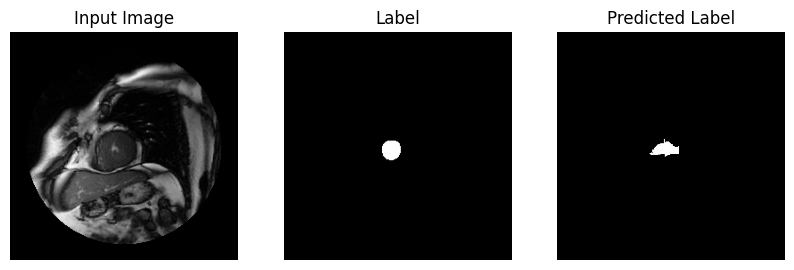


Sample Prediction after epoch 13

234/234 [==============================] - 18s 79ms/step - loss: 0.0136 - accuracy: 0.9951 - val_loss: 0.0182 - val_accuracy: 0.9935
Epoch 14/20
1/1 [==============================] - 0s 33ms/step- loss: 0.0115 - accuracy: 0.99


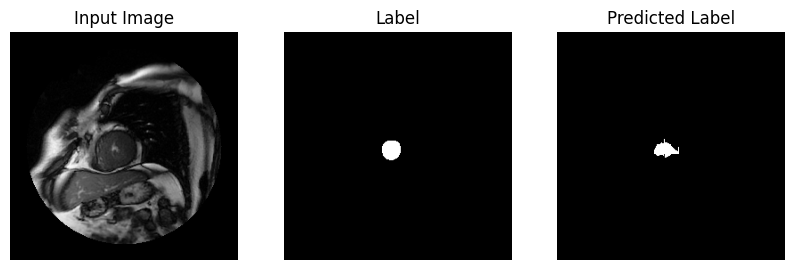


Sample Prediction after epoch 14

234/234 [==============================] - 18s 75ms/step - loss: 0.0115 - accuracy: 0.9959 - val_loss: 0.0146 - val_accuracy: 0.9945
Epoch 15/20
1/1 [==============================] - 0s 33ms/step- loss: 0.0107 - accuracy: 0.99


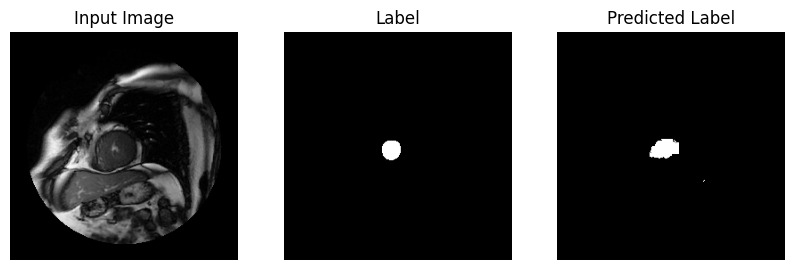


Sample Prediction after epoch 15

234/234 [==============================] - 17s 72ms/step - loss: 0.0107 - accuracy: 0.9963 - val_loss: 0.0132 - val_accuracy: 0.9950
Epoch 16/20
1/1 [==============================] - 0s 120ms/step loss: 0.0101 - accuracy: 0.99


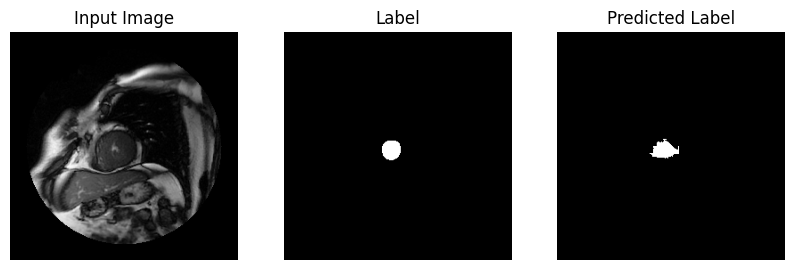


Sample Prediction after epoch 16

234/234 [==============================] - 38s 162ms/step - loss: 0.0101 - accuracy: 0.9965 - val_loss: 0.0122 - val_accuracy: 0.9954
Epoch 17/20
1/1 [==============================] - 0s 40ms/step- loss: 0.0094 - accuracy: 0.99


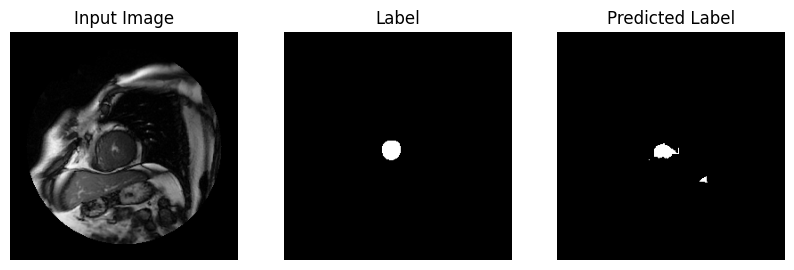


Sample Prediction after epoch 17

234/234 [==============================] - 57s 243ms/step - loss: 0.0094 - accuracy: 0.9968 - val_loss: 0.0130 - val_accuracy: 0.9953
Epoch 18/20
1/1 [==============================] - 0s 33ms/step- loss: 0.0088 - accuracy: 0.99


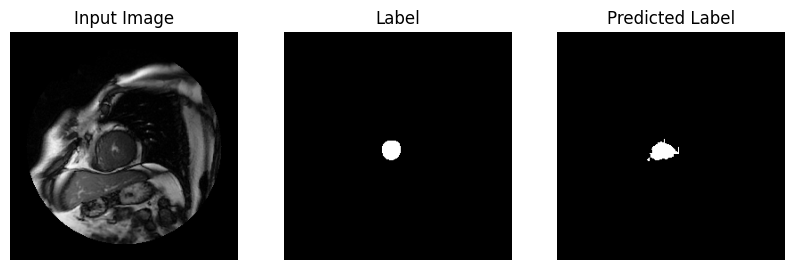


Sample Prediction after epoch 18

234/234 [==============================] - 17s 74ms/step - loss: 0.0088 - accuracy: 0.9970 - val_loss: 0.0123 - val_accuracy: 0.9952
Epoch 19/20
1/1 [==============================] - 0s 41ms/step- loss: 0.0084 - accuracy: 0.99


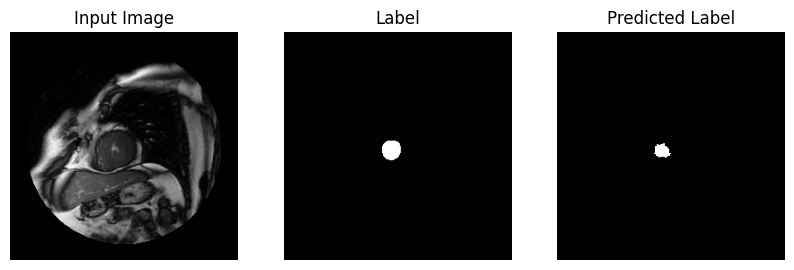


Sample Prediction after epoch 19

234/234 [==============================] - 17s 74ms/step - loss: 0.0084 - accuracy: 0.9971 - val_loss: 0.0130 - val_accuracy: 0.9954
Epoch 20/20
1/1 [==============================] - 0s 30ms/step- loss: 0.0079 - accuracy: 0.99


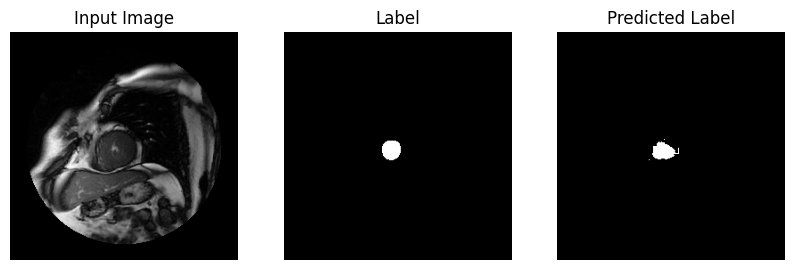


Sample Prediction after epoch 20

234/234 [==============================] - 34s 146ms/step - loss: 0.0079 - accuracy: 0.9973 - val_loss: 0.0118 - val_accuracy: 0.9957


In [31]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

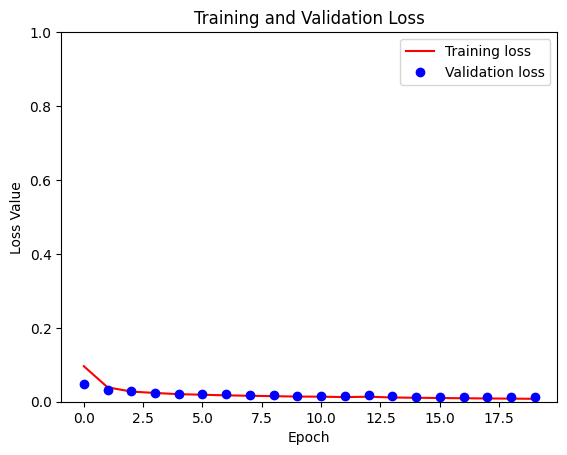

In [32]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [33]:
model.evaluate(test_dataset)

26/26 [==============================] - 1s 43ms/step - loss: 0.0118 - accuracy: 0.9957


[0.011795129626989365, 0.995735764503479]

1/1 [==============================] - 0s 40ms/step


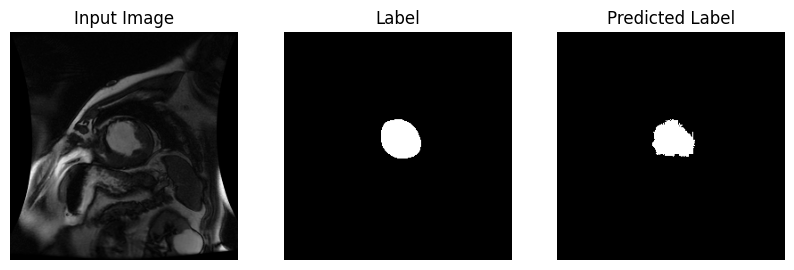

1/1 [==============================] - 0s 40ms/step


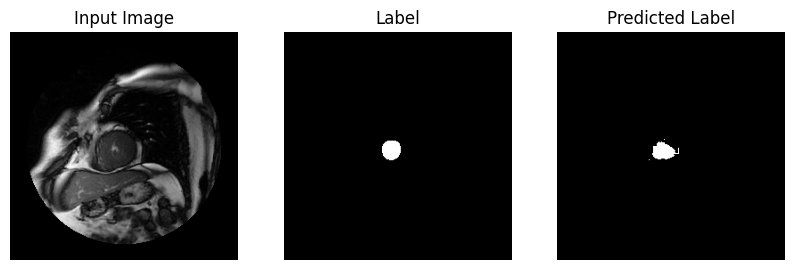

1/1 [==============================] - 0s 39ms/step


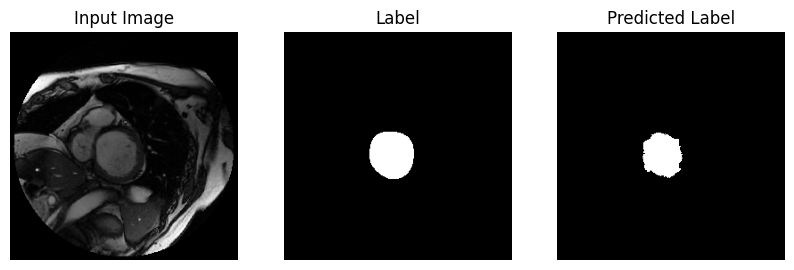

1/1 [==============================] - 0s 44ms/step


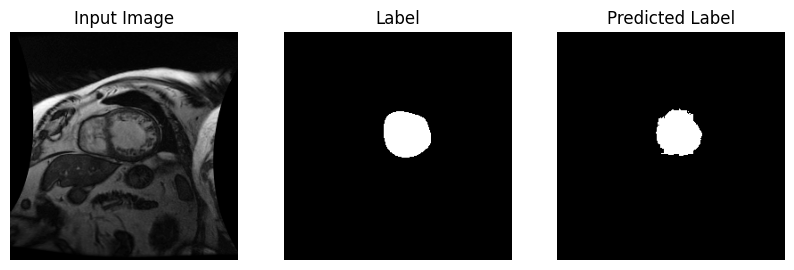

1/1 [==============================] - 0s 40ms/step


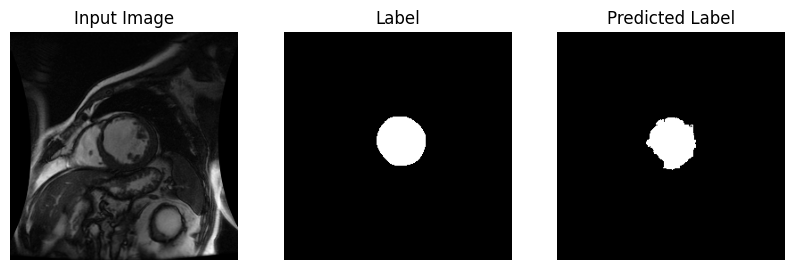

In [34]:
# show predictions from the test data set that has NOT been used for training.
show_predictions(test_dataset, 5)

In [35]:
def dice_coef(y_true, y_pred, smooth=1):
    indices = K.argmax(y_pred, 3)
    indices = K.reshape(indices, [-1, 256, 256, 1])

    true_cast = y_true
    indices_cast = K.cast(indices, dtype='float32')

    axis = [1, 2, 3]
    intersection = K.sum(true_cast * indices_cast, axis=axis)
    union = K.sum(true_cast, axis=axis) + K.sum(indices_cast, axis=axis)
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)

    return dice

In [36]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [37]:
tf.keras.backend.clear_session() 
model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[dice_coef,'accuracy'])

Epoch 1/30
1/1 [==============================] - 0s 84ms/step- loss: 0.0079 - dice_coef: 0.8698 - accuracy: 0.99


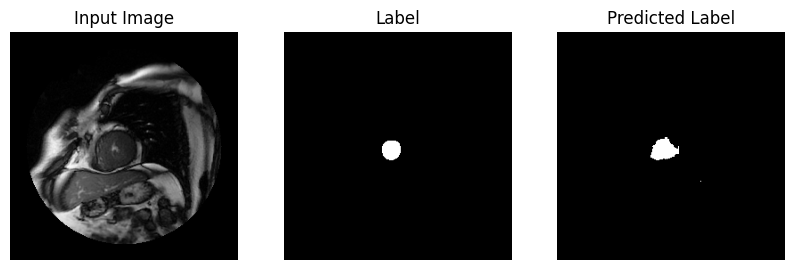


Sample Prediction after epoch 1

234/234 [==============================] - 20s 79ms/step - loss: 0.0079 - dice_coef: 0.8698 - accuracy: 0.9972 - val_loss: 0.0102 - val_dice_coef: 0.8150 - val_accuracy: 0.9962
Epoch 2/30
1/1 [==============================] - 0s 42ms/step- loss: 0.0071 - dice_coef: 0.8868 - accuracy: 0.99


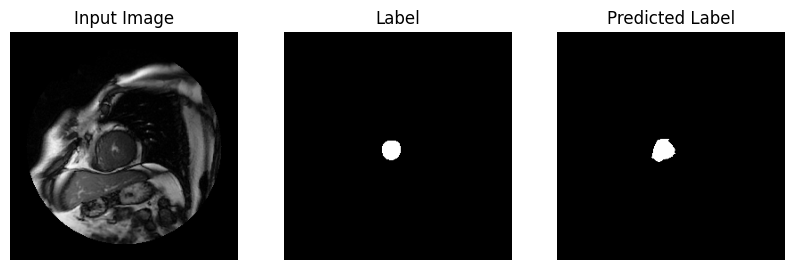


Sample Prediction after epoch 2

234/234 [==============================] - 19s 83ms/step - loss: 0.0071 - dice_coef: 0.8868 - accuracy: 0.9975 - val_loss: 0.0096 - val_dice_coef: 0.8095 - val_accuracy: 0.9964
Epoch 3/30
1/1 [==============================] - 0s 37ms/step- loss: 0.0066 - dice_coef: 0.8944 - accuracy: 0.99


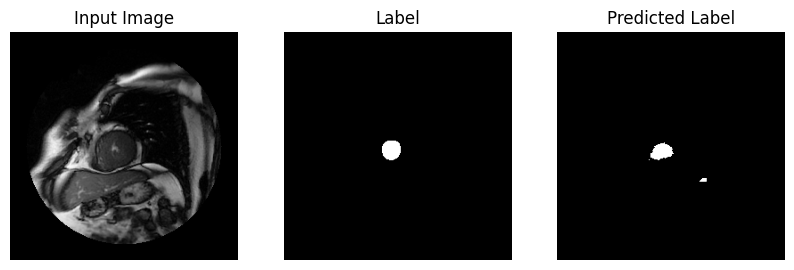


Sample Prediction after epoch 3

234/234 [==============================] - 27s 115ms/step - loss: 0.0066 - dice_coef: 0.8944 - accuracy: 0.9977 - val_loss: 0.0139 - val_dice_coef: 0.7597 - val_accuracy: 0.9956
Epoch 4/30
1/1 [==============================] - 0s 36ms/step- loss: 0.0061 - dice_coef: 0.9009 - accuracy: 0.99


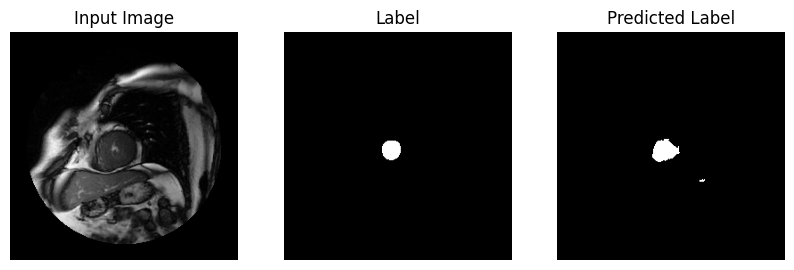


Sample Prediction after epoch 4

234/234 [==============================] - 22s 95ms/step - loss: 0.0061 - dice_coef: 0.9009 - accuracy: 0.9978 - val_loss: 0.0095 - val_dice_coef: 0.8205 - val_accuracy: 0.9962
Epoch 5/30
1/1 [==============================] - 0s 49ms/step- loss: 0.0059 - dice_coef: 0.9010 - accuracy: 0.99


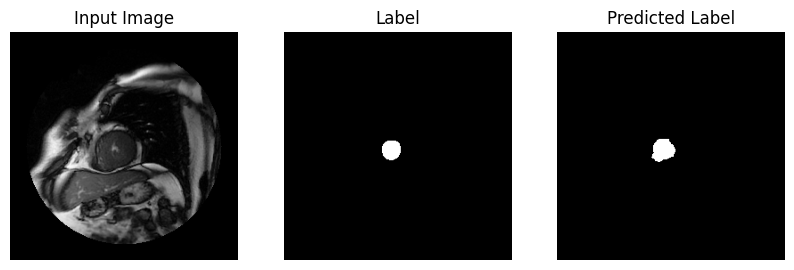


Sample Prediction after epoch 5

234/234 [==============================] - 23s 97ms/step - loss: 0.0059 - dice_coef: 0.9010 - accuracy: 0.9978 - val_loss: 0.0086 - val_dice_coef: 0.8147 - val_accuracy: 0.9966
Epoch 6/30
1/1 [==============================] - 0s 39ms/step- loss: 0.0055 - dice_coef: 0.9079 - accuracy: 0.99


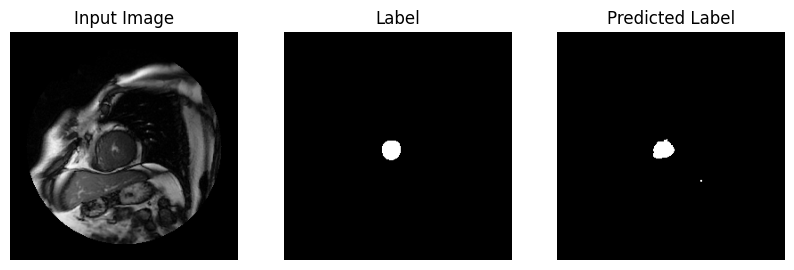


Sample Prediction after epoch 6

234/234 [==============================] - 22s 94ms/step - loss: 0.0055 - dice_coef: 0.9079 - accuracy: 0.9980 - val_loss: 0.0115 - val_dice_coef: 0.7795 - val_accuracy: 0.9959
Epoch 7/30
1/1 [==============================] - 0s 40ms/step- loss: 0.0052 - dice_coef: 0.9157 - accuracy: 0.99


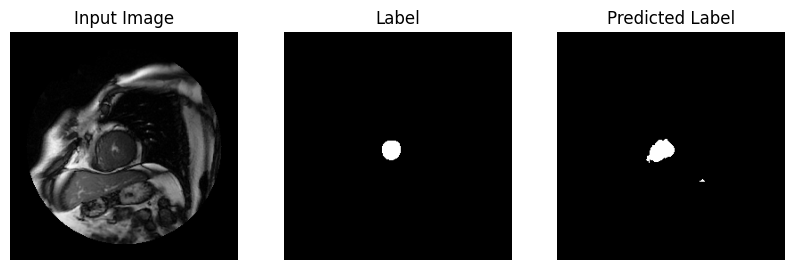


Sample Prediction after epoch 7

234/234 [==============================] - 22s 95ms/step - loss: 0.0052 - dice_coef: 0.9157 - accuracy: 0.9981 - val_loss: 0.0089 - val_dice_coef: 0.8012 - val_accuracy: 0.9966
Epoch 8/30
1/1 [==============================] - 0s 55ms/step- loss: 0.0047 - dice_coef: 0.9219 - accuracy: 0.99


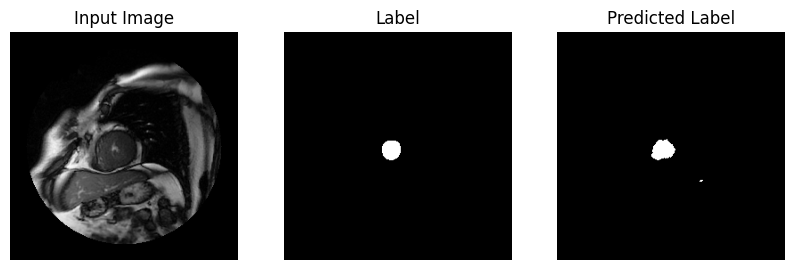


Sample Prediction after epoch 8

234/234 [==============================] - 22s 94ms/step - loss: 0.0047 - dice_coef: 0.9219 - accuracy: 0.9983 - val_loss: 0.0089 - val_dice_coef: 0.8098 - val_accuracy: 0.9968
Epoch 9/30
1/1 [==============================] - 0s 56ms/step- loss: 0.0046 - dice_coef: 0.9193 - accuracy: 0.99


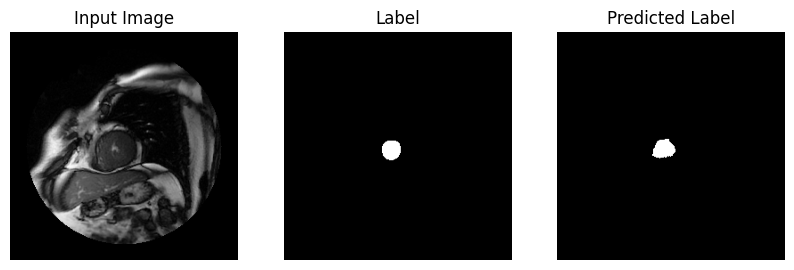


Sample Prediction after epoch 9

234/234 [==============================] - 25s 108ms/step - loss: 0.0046 - dice_coef: 0.9193 - accuracy: 0.9983 - val_loss: 0.0111 - val_dice_coef: 0.8007 - val_accuracy: 0.9963
Epoch 10/30
1/1 [==============================] - 0s 60ms/step- loss: 0.0045 - dice_coef: 0.9227 - accuracy: 0.99


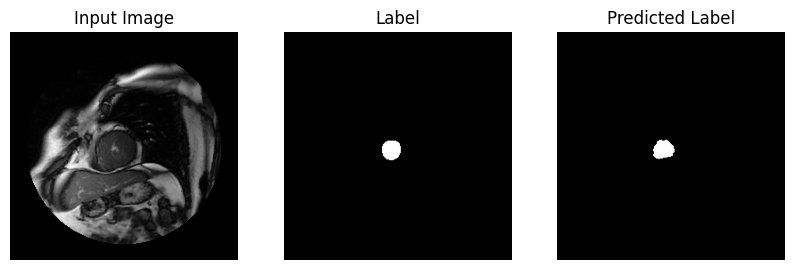


Sample Prediction after epoch 10

234/234 [==============================] - 27s 115ms/step - loss: 0.0045 - dice_coef: 0.9227 - accuracy: 0.9983 - val_loss: 0.0090 - val_dice_coef: 0.8079 - val_accuracy: 0.9969
Epoch 11/30
1/1 [==============================] - 0s 51ms/step- loss: 0.0044 - dice_coef: 0.9255 - accuracy: 0.99


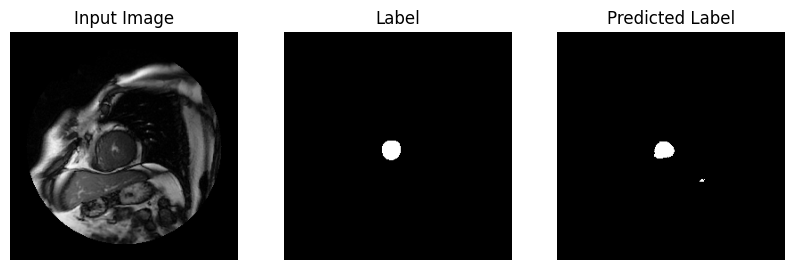


Sample Prediction after epoch 11

234/234 [==============================] - 25s 105ms/step - loss: 0.0044 - dice_coef: 0.9255 - accuracy: 0.9983 - val_loss: 0.0080 - val_dice_coef: 0.8180 - val_accuracy: 0.9970
Epoch 12/30
1/1 [==============================] - 0s 34ms/step- loss: 0.0041 - dice_coef: 0.9277 - accuracy: 0.99


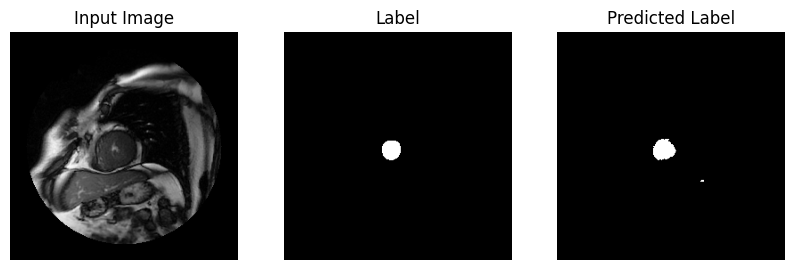


Sample Prediction after epoch 12

234/234 [==============================] - 33s 142ms/step - loss: 0.0041 - dice_coef: 0.9277 - accuracy: 0.9984 - val_loss: 0.0089 - val_dice_coef: 0.8197 - val_accuracy: 0.9969
Epoch 13/30
1/1 [==============================] - 0s 59ms/step- loss: 0.0038 - dice_coef: 0.9341 - accuracy: 0.99


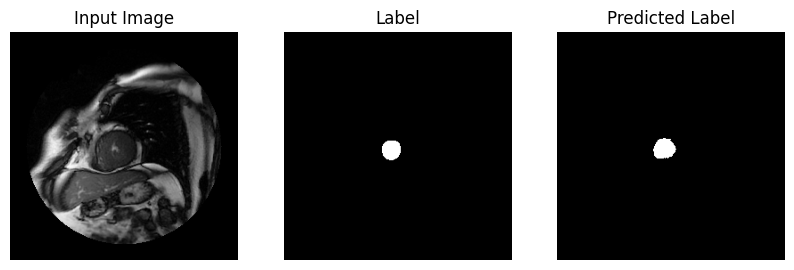


Sample Prediction after epoch 13

234/234 [==============================] - 25s 107ms/step - loss: 0.0038 - dice_coef: 0.9341 - accuracy: 0.9986 - val_loss: 0.0083 - val_dice_coef: 0.8229 - val_accuracy: 0.9971
Epoch 14/30
1/1 [==============================] - 0s 54ms/step- loss: 0.0037 - dice_coef: 0.9372 - accuracy: 0.99


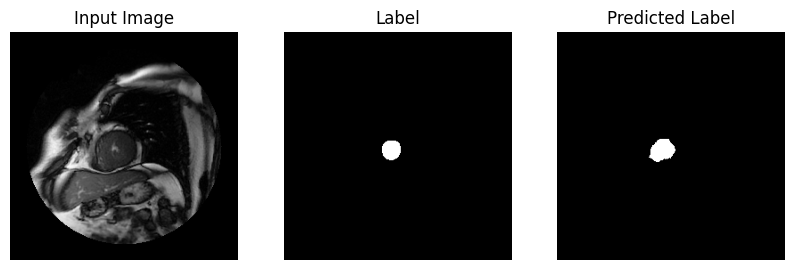


Sample Prediction after epoch 14

234/234 [==============================] - 23s 100ms/step - loss: 0.0037 - dice_coef: 0.9372 - accuracy: 0.9986 - val_loss: 0.0090 - val_dice_coef: 0.8131 - val_accuracy: 0.9968
Epoch 15/30
1/1 [==============================] - 0s 44ms/step- loss: 0.0037 - dice_coef: 0.9353 - accuracy: 0.99


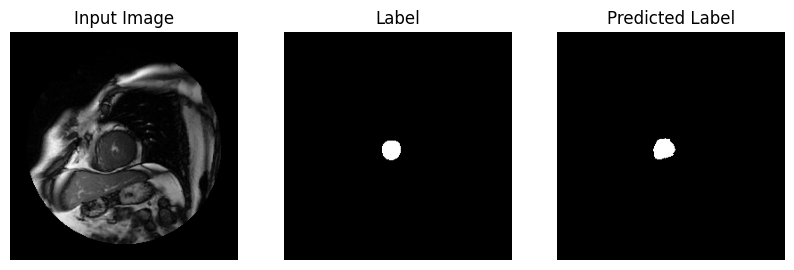


Sample Prediction after epoch 15

234/234 [==============================] - 23s 97ms/step - loss: 0.0037 - dice_coef: 0.9353 - accuracy: 0.9986 - val_loss: 0.0098 - val_dice_coef: 0.8237 - val_accuracy: 0.9968
Epoch 16/30
1/1 [==============================] - 0s 45ms/step- loss: 0.0038 - dice_coef: 0.9317 - accuracy: 0.99


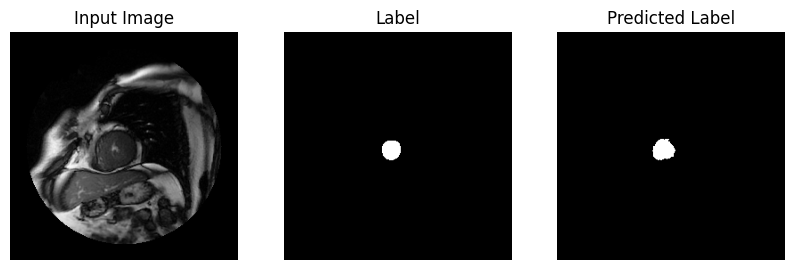


Sample Prediction after epoch 16

234/234 [==============================] - 22s 96ms/step - loss: 0.0038 - dice_coef: 0.9317 - accuracy: 0.9985 - val_loss: 0.0083 - val_dice_coef: 0.8289 - val_accuracy: 0.9969
Epoch 17/30
1/1 [==============================] - 0s 98ms/step- loss: 0.0037 - dice_coef: 0.9380 - accuracy: 0.99


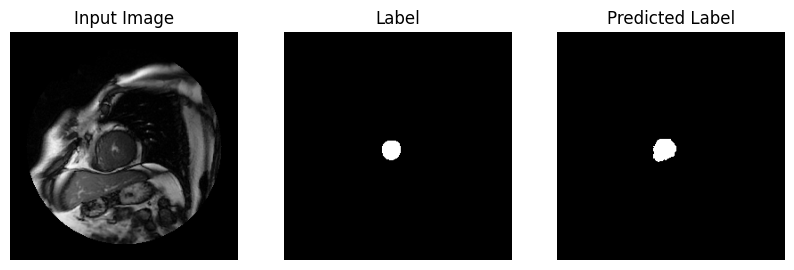


Sample Prediction after epoch 17

234/234 [==============================] - 39s 167ms/step - loss: 0.0037 - dice_coef: 0.9380 - accuracy: 0.9985 - val_loss: 0.0083 - val_dice_coef: 0.8275 - val_accuracy: 0.9970
Epoch 18/30
1/1 [==============================] - 0s 42ms/step- loss: 0.0035 - dice_coef: 0.9367 - accuracy: 0.99


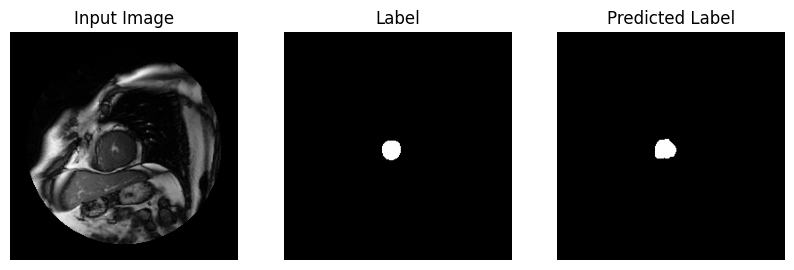


Sample Prediction after epoch 18

234/234 [==============================] - 45s 191ms/step - loss: 0.0035 - dice_coef: 0.9367 - accuracy: 0.9986 - val_loss: 0.0094 - val_dice_coef: 0.8249 - val_accuracy: 0.9970
Epoch 19/30
1/1 [==============================] - 0s 244ms/step loss: 0.0033 - dice_coef: 0.9419 - accuracy: 0.99


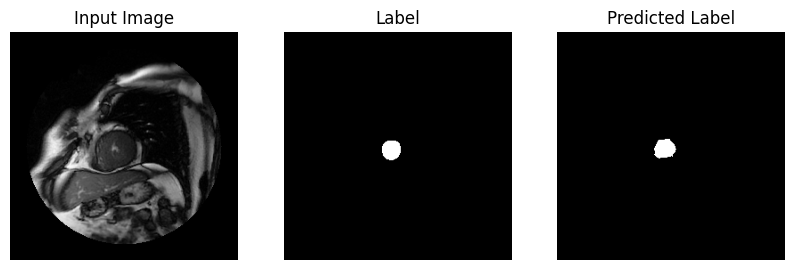


Sample Prediction after epoch 19

234/234 [==============================] - 58s 247ms/step - loss: 0.0033 - dice_coef: 0.9419 - accuracy: 0.9987 - val_loss: 0.0075 - val_dice_coef: 0.8427 - val_accuracy: 0.9973
Epoch 20/30
1/1 [==============================] - 0s 148ms/step loss: 0.0032 - dice_coef: 0.9446 - accuracy: 0.99


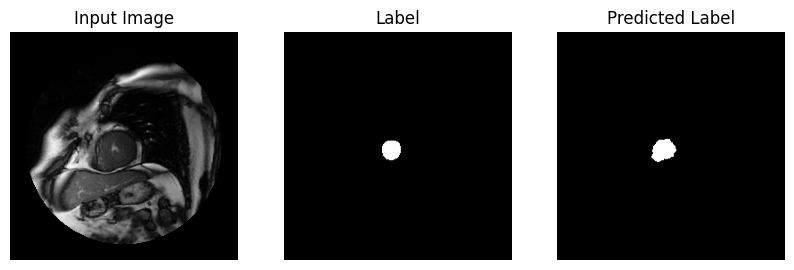


Sample Prediction after epoch 20

234/234 [==============================] - 64s 276ms/step - loss: 0.0032 - dice_coef: 0.9446 - accuracy: 0.9988 - val_loss: 0.0092 - val_dice_coef: 0.8196 - val_accuracy: 0.9969
Epoch 21/30
1/1 [==============================] - 0s 88ms/step- loss: 0.0033 - dice_coef: 0.9381 - accuracy: 0.99


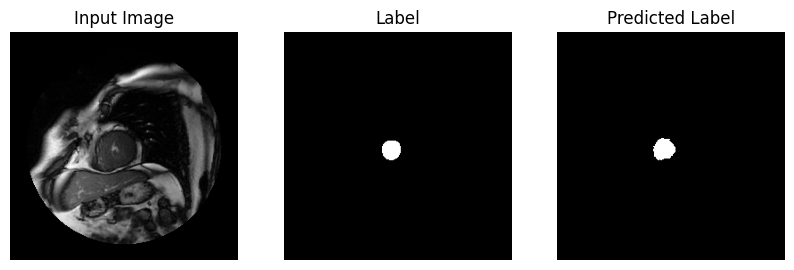


Sample Prediction after epoch 21

234/234 [==============================] - 38s 163ms/step - loss: 0.0033 - dice_coef: 0.9381 - accuracy: 0.9987 - val_loss: 0.0084 - val_dice_coef: 0.8270 - val_accuracy: 0.9970
Epoch 22/30
1/1 [==============================] - 0s 49ms/step- loss: 0.0034 - dice_coef: 0.9370 - accuracy: 0.99


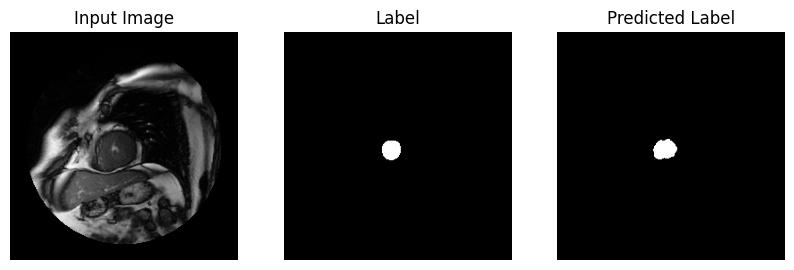


Sample Prediction after epoch 22

234/234 [==============================] - 35s 148ms/step - loss: 0.0034 - dice_coef: 0.9370 - accuracy: 0.9986 - val_loss: 0.0076 - val_dice_coef: 0.8505 - val_accuracy: 0.9971
Epoch 23/30
1/1 [==============================] - 0s 48ms/step- loss: 0.0032 - dice_coef: 0.9439 - accuracy: 0.99


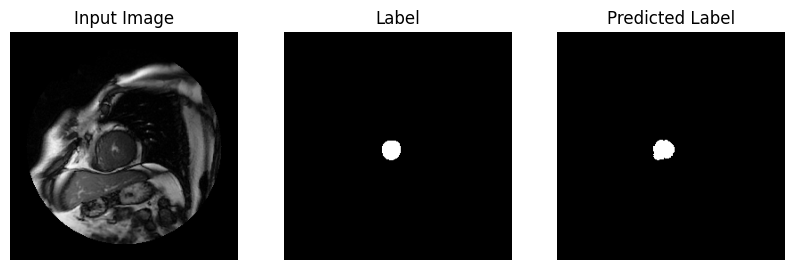


Sample Prediction after epoch 23

234/234 [==============================] - 23s 100ms/step - loss: 0.0032 - dice_coef: 0.9439 - accuracy: 0.9987 - val_loss: 0.0080 - val_dice_coef: 0.8299 - val_accuracy: 0.9972
Epoch 24/30
1/1 [==============================] - 0s 61ms/step- loss: 0.0031 - dice_coef: 0.9421 - accuracy: 0.99


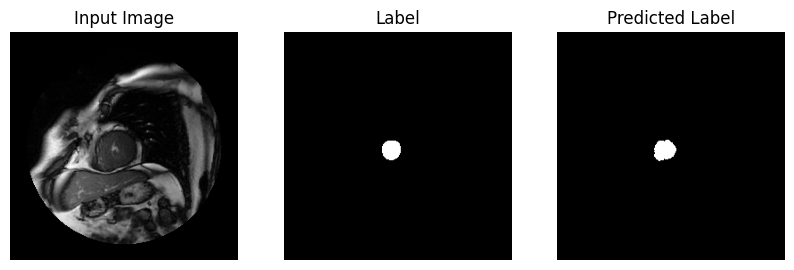


Sample Prediction after epoch 24

234/234 [==============================] - 24s 103ms/step - loss: 0.0031 - dice_coef: 0.9421 - accuracy: 0.9988 - val_loss: 0.0077 - val_dice_coef: 0.8393 - val_accuracy: 0.9972
Epoch 25/30
1/1 [==============================] - 0s 48ms/step- loss: 0.0030 - dice_coef: 0.9457 - accuracy: 0.99


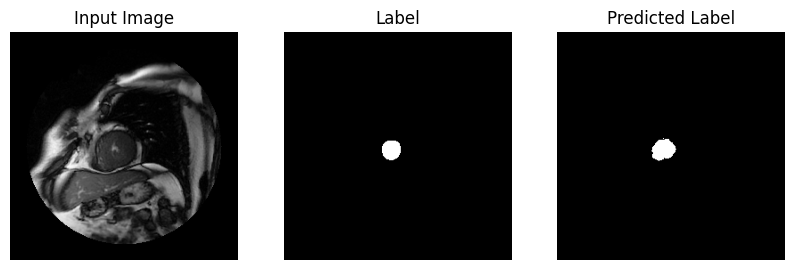


Sample Prediction after epoch 25

234/234 [==============================] - 23s 99ms/step - loss: 0.0030 - dice_coef: 0.9457 - accuracy: 0.9988 - val_loss: 0.0082 - val_dice_coef: 0.8370 - val_accuracy: 0.9971
Epoch 26/30
1/1 [==============================] - 0s 58ms/step- loss: 0.0029 - dice_coef: 0.9487 - accuracy: 0.99


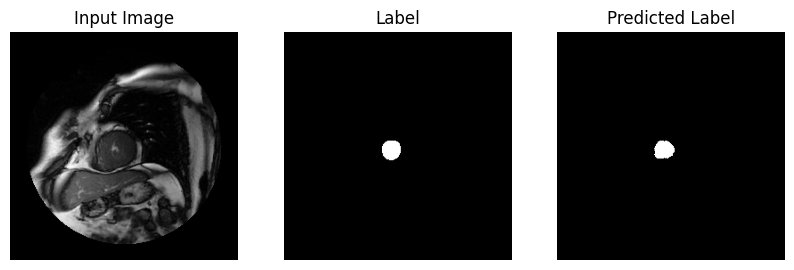


Sample Prediction after epoch 26

234/234 [==============================] - 23s 96ms/step - loss: 0.0029 - dice_coef: 0.9487 - accuracy: 0.9989 - val_loss: 0.0090 - val_dice_coef: 0.8223 - val_accuracy: 0.9971
Epoch 27/30
1/1 [==============================] - 0s 50ms/step- loss: 0.0030 - dice_coef: 0.9443 - accuracy: 0.99


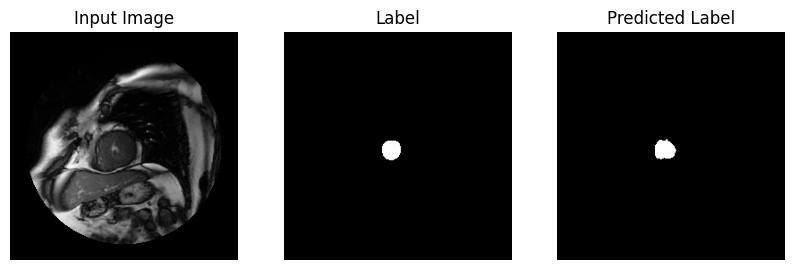


Sample Prediction after epoch 27

234/234 [==============================] - 24s 105ms/step - loss: 0.0030 - dice_coef: 0.9443 - accuracy: 0.9988 - val_loss: 0.0074 - val_dice_coef: 0.8525 - val_accuracy: 0.9974
Epoch 28/30
1/1 [==============================] - 0s 50ms/step- loss: 0.0029 - dice_coef: 0.9471 - accuracy: 0.99


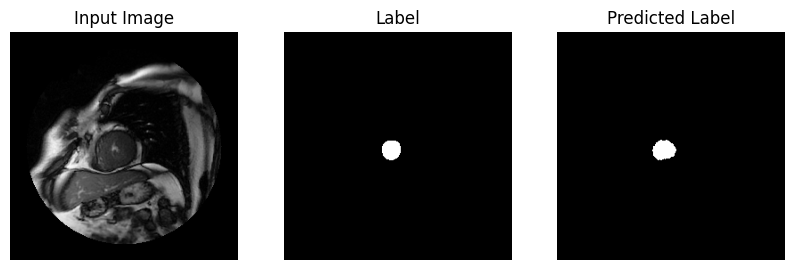


Sample Prediction after epoch 28

234/234 [==============================] - 23s 98ms/step - loss: 0.0029 - dice_coef: 0.9471 - accuracy: 0.9988 - val_loss: 0.0082 - val_dice_coef: 0.8387 - val_accuracy: 0.9971
Epoch 29/30
1/1 [==============================] - 0s 216ms/step loss: 0.0029 - dice_coef: 0.9481 - accuracy: 0.99


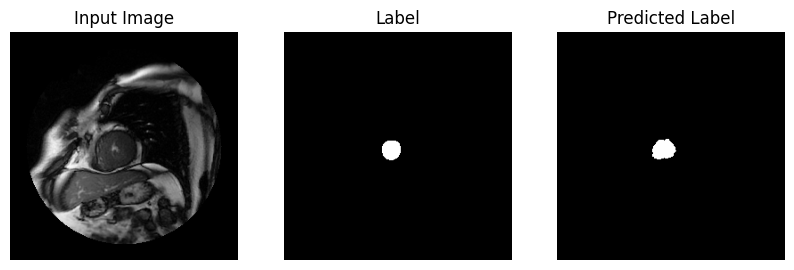


Sample Prediction after epoch 29

234/234 [==============================] - 37s 159ms/step - loss: 0.0029 - dice_coef: 0.9481 - accuracy: 0.9989 - val_loss: 0.0088 - val_dice_coef: 0.8254 - val_accuracy: 0.9970
Epoch 30/30
1/1 [==============================] - 0s 161ms/step loss: 0.0029 - dice_coef: 0.9485 - accuracy: 0.99


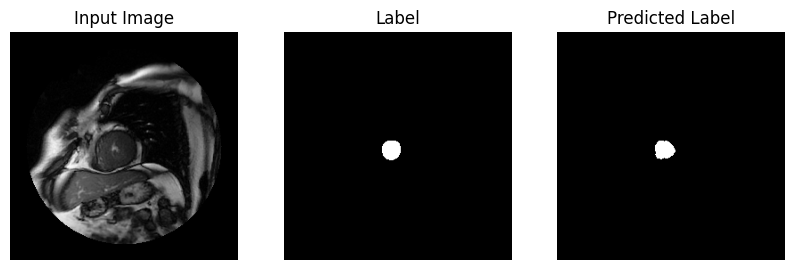


Sample Prediction after epoch 30

234/234 [==============================] - 63s 267ms/step - loss: 0.0029 - dice_coef: 0.9485 - accuracy: 0.9988 - val_loss: 0.0088 - val_dice_coef: 0.8333 - val_accuracy: 0.9972


In [38]:
 # setup and run the model
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

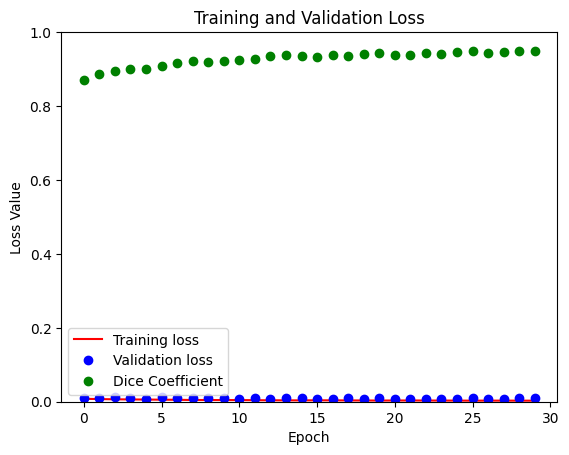

In [39]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()
